In [149]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Optional, List, Annotated
from langgraph.channels import LastValue
import requests
import json
from dotenv import load_dotenv
import os
import asyncio
from runware import Runware, IImageInference
from PIL import Image
from io import BytesIO
import google.generativeai as genai
from IPython.display import display

In [150]:
load_dotenv()

GROQ_API = os.getenv("GROQ_API")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
RUNWARE_API_KEY = os.getenv("RUNWARE_API_KEY")

# You should configure your API key outside the function (only once)
genai.configure(api_key=GOOGLE_API_KEY)

In [151]:
class AgentState(TypedDict):
    user_id: str
    project_id: str
    name: str  # project_name
    product_name: str
    description: str
    price: float
    discount: float
    image_ids: List[str]
    target_audience: str
    output_format: str
    status: str  
    generationDone: str
    generated_outputs_id: str
    automate_campaign: Optional[bool]
    
    text_prompt: str
    image_prompt: str
    video_prompt: str

    text_output: Annotated[Optional[str], LastValue(Optional[str])]
    image_output: Annotated[Optional[str], LastValue(Optional[str])]
    video_output: Annotated[Optional[str], LastValue(Optional[str])]

In [152]:
def manager_router(state: AgentState) -> str:
    gen_status = state.get("generationDone")

    if gen_status in (None, "NotStarted"):
        return "generate"
    elif gen_status == "Generated":
        return "display"
    elif gen_status == "Edit":
        return "edit"
    elif gen_status == "Automate":
        return "automate"
    elif gen_status == "Finalized":
        return "Done"
    else:
        raise ValueError(f"Invalid generationDone value: {gen_status}")

    

def storage_decider(state:AgentState) -> str:
    if not state.get("generated_outputs_id"):
        return "store"
    
    return "stored"


In [153]:
def generate_prompt(state: AgentState) -> dict:
    # Extract relevant fields from state
    product_name = state.get("product_name", "")
    description = state.get("description", "")
    discount = state.get("discount", 0.0)
    target_audience = state.get("target_audience", "")
    output_format = state.get("output_format", "")

    # Enhanced system prompt
    system_prompt = (
        "You are an expert prompt engineer.\n"
        "Based on the marketing content provided by the user, your job is to generate highly effective generation prompts for a multimodal LLMs.\n"
        "You must:\n"
        "- Determine what the user wants based on their output format description.\n"
        "- Generate prompts for text, image, and video accordingly.\n"
        "- All prompts should reflect the tone, platform, and audience expectations.\n"
        "- Do not add your own assumptions — follow the user description strictly.\n"
        "- Return a JSON response with only relevant fields filled.\n\n"
        "Only return:\n"
        "{\n"
        "  \"text_prompt\": \"...\" or null,\n"
        "  \"image_prompt\": \"...\" or null,\n"
        "  \"video_prompt\": \"...\" or null\n"
        "}"
    )

    # Build user message
    user_message = (
        f"Product Name: {product_name}\n"
        f"Description: {description}\n"
        f"Discount: {discount}% off\n"
        f"Target Audience: {target_audience}\n"
        f"Desired Output Format: {output_format}\n\n"
        f"Generate highly effective prompts suitable for generating this kind of content."
    )

    data = {
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_message}
        ],
        "model": "llama-3.1-8b-instant",
        "temperature": 0.7
    }

    headers = {
        "Authorization": f"Bearer {GROQ_API}",
        "Content-Type": "application/json"
    }

    prompts = {
        "text_prompt": None,
        "image_prompt": None,
        "video_prompt": None
    }

    try:
        response = requests.post(
            "https://api.groq.com/openai/v1/chat/completions",
            headers=headers,
            json=data,
            timeout=15
        )
        response.raise_for_status()
        try:
            result = response.json()["choices"][0]["message"]["content"]
            prompts = json.loads(result)
        except Exception as e:
            print("Groq response parsing failed:", e)
            print("Raw response:", response.text)
            raise

    except Exception as e:
        print("Prompt generation failed:", e)

    return {
        "text_prompt": prompts.get("text_prompt"),
        "image_prompt": prompts.get("image_prompt"),
        "video_prompt": prompts.get("video_prompt"),
    }


In [154]:
# Text Generation Agent

def text_agent(state: AgentState) -> dict:
    if not state.get("text_prompt"):
        return {"text_output": None}

    # Retrieve the prompt
    text_prompt = state.get("text_prompt", "")
    project_id = state.get("project_id", "")

    # Define system instructions
    system_prompt = (
        "You are a senior marketing copywriter for a global brand.\n"
        "Your task is to generate short, compelling marketing messages based on a given prompt.\n"
        "The response must:\n"
        "- Be persuasive and engaging.\n"
        "- Reflect modern, brand-aware language.\n"
        "- Be clear and emotionally resonant for the target audience.\n"
        "- Not exceed 2 paragraphs.\n"
        "- Be ready to publish without further editing."
    )

    try:
        # Generate the text using Gemini
        model = genai.GenerativeModel(
            model_name="gemini-2.5-flash",
            system_instruction=system_prompt
        )
        response = model.generate_content(text_prompt)
        generated_text = response.text.strip()

        print("Generated Text:\n", generated_text)

        # ⬇️ Upload to FastAPI endpoint
        api_url = f"http://127.0.0.1:8000/api/project/upload-generated-text/{project_id}"

        res = requests.put(
            api_url,
            data={"text": generated_text}
        )

        if res.status_code == 200:
            print("✅ Text uploaded to server")
        else:
            print("❌ Upload failed:", res.status_code, res.text)

        return {"text_output": generated_text}

    except Exception as e:
        print("Generation or upload failed:", e)
        return {"text_output": None}


async def image_agent(state: AgentState) -> dict:
    if not state.get("image_prompt"):
        return {"image_output": None}

    project_id = state.get('project_id')
    runware = Runware(api_key=RUNWARE_API_KEY)
    await runware.connect()

    request = IImageInference(
        positivePrompt= state.get('image_prompt'),
        model="runware:101@1",
        width=1024,
        height=1024
    )

    try:
        images = await runware.imageInference(requestImage=request)
        image_url = images[0].imageURL

        response = requests.get(image_url)
        image_bytes = BytesIO(response.content)
        img = Image.open(image_bytes)
        display(img)

        files = {
            "image_output": ("generated.jpg", image_bytes, "image/jpeg")
        }
        
        
        api_url = f"http://127.0.0.1:8000/api/project/upload-generated-image/{project_id}"

        res = requests.put(
            api_url, 
            files=files
        )

        if res.status_code == 200:
            print("✅ Image uploaded to server")
        else:
            print("❌ Upload failed:", res.status_code, res.text)

        return {"image_output": image_url}

    except Exception as e:
        print("Generation or upload failed:", e)
        return {"image_output": None}


def video_agent(state: AgentState) -> dict:
    return {
        "video_output": None  # or actual output
    }

In [155]:
def router_op(state: AgentState) -> dict:
    project_id = state.get("project_id")

    try:
        api_url = f"http://127.0.0.1:8000/api/project/update/generated-output/{project_id}"
        res = requests.put(api_url, data={"project_id": project_id})

        if res.status_code == 200:
            print("✅ Generated Output Linked to project")
            return {"generationDone": "Generated"}
        else:
            print("❌ Linking failed:", res.status_code, res.text)
            return {"generationDone": None}

    except Exception as e:
        print("Linking Failed:", e)
        return {"generationDone": None}


In [156]:
def manager_agent(state: AgentState)->dict:
    return {}

In [157]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

# Define agents
graph.add_node("manager", manager_agent)
graph.add_node("prompt_generator", generate_prompt)
graph.add_node("text_model", text_agent)
graph.add_node("image_model", image_agent)
graph.add_node("video_model", video_agent)
graph.add_node("router", router_op)

# Entry point
graph.set_entry_point("manager")

# Manager branching
graph.add_conditional_edges(
    "manager",
    manager_router,
    {
        "generate": "prompt_generator",
        "display": END
    }
)

# Conditional routing based on presence of prompts
# From prompt_generator, go to all three models in parallel
graph.add_edge("prompt_generator", "text_model")
graph.add_edge("prompt_generator", "image_model")
graph.add_edge("prompt_generator", "video_model")


# Output agents route to router
graph.add_edge("text_model", "router")
graph.add_edge("image_model", "router")
graph.add_edge("video_model", "router")

# Router loops back to manager
graph.add_edge("router", "manager")

# Compile graph
app = graph.compile()


In [158]:
test_state = {
    "user_id": "685f77cddb71ef9dc0409563",
    "project_id": "686369a1028c174e2723a11f",
    "name": "Summer Campaign",
    "product_name": "AI Marketing Bot",
    "description": "An AI-powered tool to automate digital marketing campaigns across multiple platforms.",
    "price": 49.99,
    "discount": 10.0,
    "image_ids": ["img_001", "img_002", "img_003"],
    "target_audience": "Category: Tech | Location: Global | Gender: both | Ages: 19-25, 26-40",
    "output_format": "Text + Image content bundle",
    "status": "initiated",
    "generationDone": "NotStarted",
    "generated_outputs_id": None,
    "automate_campaign": None,
    
    "text_prompt": None,
    "image_prompt": None,
    "video_prompt": None,
    
    "text_output": None,
    "image_output": None,
    "video_output": None,
}


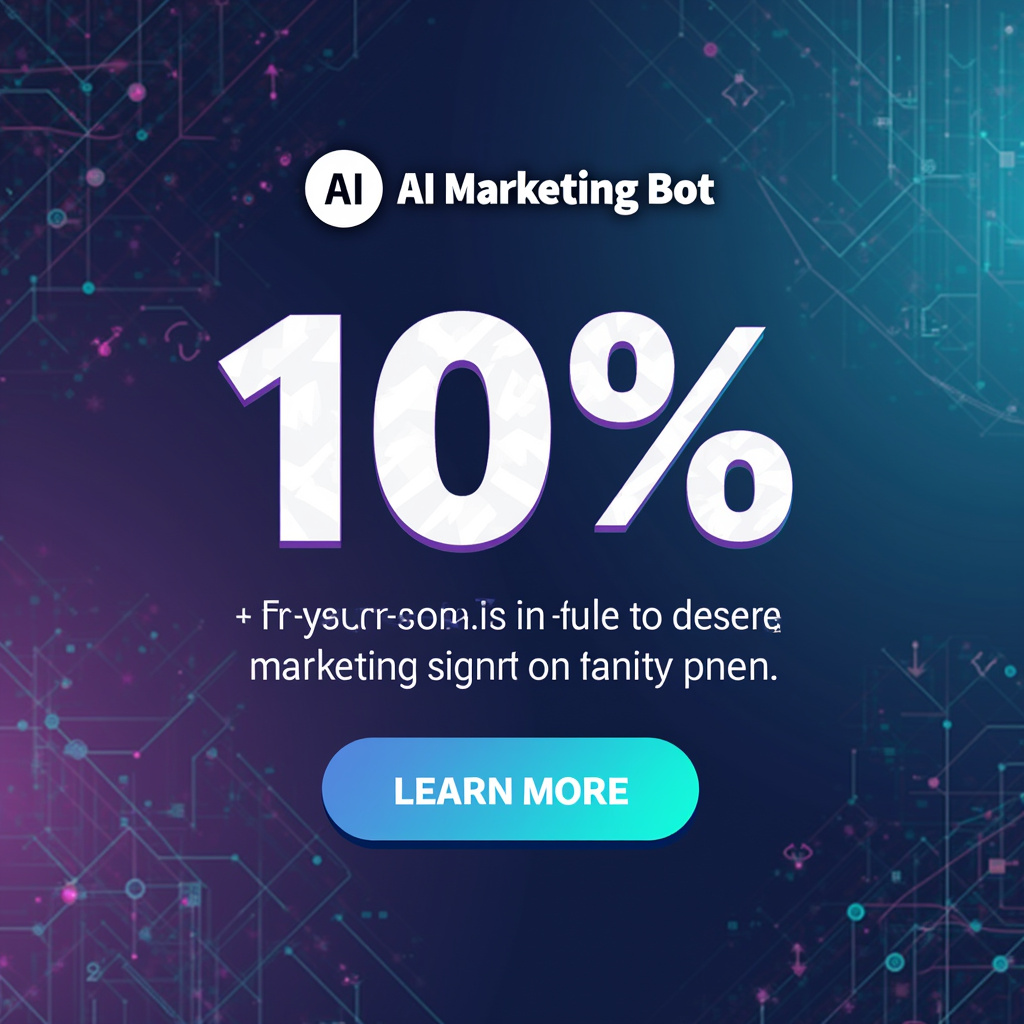

✅ Image uploaded to server
Generated Text:
 Transform your digital marketing from a manual grind into a smart, data-driven powerhouse. Our AI Marketing Bot isn't just an automation tool; it's your strategic co-pilot, intelligently learning, optimizing, and performing to deliver unparalleled campaign success. Imagine reclaiming hours spent on repetitive tasks, while your campaigns autonomously craft compelling content, pinpoint high-potential audiences, and scale with precision – all designed to supercharge your reach and amplify your ROI.

Harnessing cutting-edge machine learning, our Bot goes beyond basic scheduling, offering predictive analytics, real-time optimization, and automated A/B testing to ensure your efforts hit the mark every time. Ready to redefine efficiency and unlock exponential growth for your brand or project? For a limited time, seize the opportunity to claim a 10% discount on the AI Marketing Bot and empower your digital strategy with the intelligence it deserves.


In [161]:
# Define the async function as usual
async def main():
    final_state = await app.ainvoke(test_state)
    print("\n--- FINAL STATE ---")
    for k, v in final_state.items():
        print(f"{k}: {v}")

# Then just await it directly in the cell
await main()

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [33]:
import requests

API_KEY = "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"

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json",
    "X-Title": "DeepSeek Prompt Generator",
}

data = {
    "model": "deepseek/deepseek-r1-0528:free",
    "messages": [
        {"role": "system", "content": "You are a helpful assistant skilled in generating prompts for text, image, and video generation."},
        {"role": "user", "content": "Generate an image prompt for a cyberpunk futuristic cityscape at night."}
    ]
}

response = requests.post("https://openrouter.ai/api/v1/chat/completions", headers=headers, json=data)

print(response.json()['choices'][0]['message']['content'])

Here's a detailed, stylized prompt for an AI image generator (like Midjourney, DALL-E, or Stable Diffusion). It blends high detail, atmosphere, and cyberpunk tropes:  

**Prompt:**  
`Cyberpunk metropolis at night, hyperrealistic octane render, Unreal Engine 5. Neon-drenched skyscrapers with holographic billboards flickering kanji and corporate logos. Glossy wet streets reflecting vibrant purple, electric blue, and acid-green neon lights. Flying cars (aerocars) streaking red taillights through smog-choked air. Massive, oppressive megastructures loom over cluttered alleyways with street vendors selling synth-noodles. Giant hologram of a geisha dissolves into code rain. Hazy volumetric lighting, chromatic aberration, cinematic wide-angle shot. Moody, dystopian, future-noir atmosphere with deep shadows and high contrast. Style: Masamune Shirow meets Blade Runner 2049 + detailed grit.`  

**Key elements reinforced:**  
- **Lighting:** Volumetric fog, neon reflections on wet asphalt, glowin

In [35]:
import requests
from typing import Dict

API_KEY = "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"

def generate_prompt(state: Dict) -> Dict:
    output_format = state.get("output_format", "")
    
    system_prompt = (
        "You are a helpful assistant that extracts exactly what type of content the user wants to generate "
        "based on their output description.\n\n"
        "Your job is to:\n"
        "- Understand *which types* of media the user wants (text, image, video).\n"
        "- Generate tailored prompts that reflect the user's intended tone, platform, structure, and audience.\n"
        "- Do not add your own assumptions — follow the user description strictly.\n\n"
        "Respond ONLY in valid JSON like:\n"
        "{\n"
        "  \"text_prompt\": \"...\" or null,\n"
        "  \"image_prompt\": \"...\" or null,\n"
        "  \"video_prompt\": \"...\" or null\n"
        "}\n\n"
        "If a type of content isn't mentioned, return null for that field."
    )

    data = {
        "model": "deepseek/deepseek-r1-0528:free",
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"User Output Format Description: {output_format}"}
        ]
    }

    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json",
        "X-Title": "DeepSeek Prompt Generator"
    }

    try:
        response = requests.post(
            "https://openrouter.ai/api/v1/chat/completions",
            headers=headers,
            json=data,
            timeout=15  # optional: avoid hanging too long
        )
        response.raise_for_status()
        result = response.json()['choices'][0]['message']['content']

        # Parse JSON response (assuming it's JSON as instructed)
        import json
        prompts = json.loads(result)

        # Update the state with generated prompts
        state['text_prompt'] = prompts.get("text_prompt")
        state['image_prompt'] = prompts.get("image_prompt")
        state['video_prompt'] = prompts.get("video_prompt")

    except Exception as e:
        print("Prompt generation failed:", e)
        state['text_prompt'] = None
        state['image_prompt'] = None
        state['video_prompt'] = None

    return state


In [36]:

# -------------------------------
# 🔹 Example state (trial input)
# -------------------------------
trial_state = {
    "output_format": "I want a catchy tweet for Gen Z about my AI-powered makeup tool, with emojis, a product image in Y2K aesthetic, and a 5-second TikTok video showing quick usage."
}

# 🔹 Run the call
updated_state = generate_prompt(trial_state)

# 🔹 Print what we get back
print("Text Prompt:", updated_state["text_prompt"])
print("Image Prompt:", updated_state["image_prompt"])
print("Video Prompt:", updated_state["video_prompt"])

Text Prompt: Write a catchy Gen Z-targeted tweet for an AI-powered makeup tool. Include emojis, slang, and hashtags. Focus on vibes like 'instant glow-up', 'no effort', and 'future beauty'. Keep it under 280 characters.
Image Prompt: Product photo for AI makeup tool in Y2K aesthetic: holographic textures, pastel gradients, glitter backgrounds, chunky digital elements, and retro-futuristic tech vibes. Include a sleek virtual makeup interface overlay with playful, early-2000s aesthetics.
Video Prompt: 5-second TikTok showing quick use of AI makeup tool: Start with bare face, rapid swipe/swipe effect applying virtual lipstick + eyeshadow, ending with sparkling filter transition. Use fast cuts, trending glitter transitions, upbeat snippet of viral sound, and Gen Z-friendly captions like 'Magic? ✨ AI Makeup!'


In [111]:
import requests
import json

def generate_prompt(state):
    API_KEY = "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"

    # Extract relevant fields from state
    product_name = state.get("product_name", "")
    description = state.get("description", "")
    discount = state.get("discount", 0.0)
    target_audience = state.get("target_audience", "")
    output_format = state.get("output_format", "")

    # Enhanced system prompt
    system_prompt = (
        "You are an expert prompt engineer.\n"
        "Based on the marketing content provided by the user, your job is to generate highly effective generation prompts for a multimodal AI.\n"
        "You must:\n"
        "- Determine what the user wants based on their output format description.\n"
        "- Generate prompts for text, image, and video accordingly.\n"
        "- All prompts should reflect the tone, platform, and audience expectations.\n"
        "- Do not add your own assumptions — follow the user description strictly.\n"
        
        "- Return a JSON response with only relevant fields filled.\n\n"
        "Only return:\n"
        "{\n"
        "  \"text_prompt\": \"...\" or null,\n"
        "  \"image_prompt\": \"...\" or null,\n"
        "  \"video_prompt\": \"...\" or null\n"
        "}"
    )

    # Build user context message
    user_message = (
        f"Product Name: {product_name}\n"
        f"Description: {description}\n"
        f"Discount: {discount}% off\n"
        f"Target Audience: {target_audience}\n"
        f"Desired Output Format: {output_format}\n\n"
        f"Generate highly effective prompts suitable for generating this kind of content."
    )

    data = {
        "model": "deepseek/deepseek-r1-0528:free",
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_message}
        ]
    }

    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json",
        "X-Title": "DeepSeek Prompt Generator"
    }

    try:
        response = requests.post(
            "https://openrouter.ai/api/v1/chat/completions",
            headers=headers,
            json=data,
            timeout=15
        )
        response.raise_for_status()
        result = response.json()["choices"][0]["message"]["content"]
        prompts = json.loads(result)

        # Update state
        state["text_prompt"] = prompts.get("text_prompt")
        state["image_prompt"] = prompts.get("image_prompt")
        state["video_prompt"] = prompts.get("video_prompt")

    except Exception as e:
        print("Prompt generation failed:", e)
        state["text_prompt"] = None
        state["image_prompt"] = None
        state["video_prompt"] = None

    return state


In [ ]:
test_state = {
    "user_id": "user_123",
    "project_id": "proj_abc456",
    "name": "Summer Campaign",
    "product_name": "AI Marketing Bot",
    "description": "An AI-powered tool to automate digital marketing campaigns across multiple platforms.",
    "price": 49.99,
    "discount": 10.0,
    "image_ids": ["img_001", "img_002", "img_003"],
    "target_audience": "Category: Tech | Location: Global | Gender: both | Ages: 19-25, 26-40",
    "output_format": "Text + Video + Image content bundle",
    "status": "initiated",
    "generationDone": False,
    "generated_outputs_id": None,
    "automate_campaign": None
}

# Run it
updated_state = generate_prompt(test_state)
print(json.dumps({
    "text_prompt": updated_state["text_prompt"],
    "image_prompt": updated_state["image_prompt"],
    "video_prompt": updated_state["video_prompt"]
}, indent=2))


{
  "text_prompt": "Create engaging marketing copy for AI Marketing Bot, an AI-powered tool automating multi-platform digital campaigns. Target global tech professionals aged 19-40. Highlight key benefits: time-saving automation, multi-platform support, and 10% launch discount. Use persuasive, energetic tone with smart emojis and tech jargon. Include clear CTA for limited-time offer.",
  "image_prompt": "Modern flat illustration showing AI marketing bot hovering above interconnected social platforms (Instagram, Twitter, Facebook icons). Vibrant gradient background (teal to purple) with digital particles. Robot arm placing campaign elements onto platforms. Include clean typography: 'Automate Your Marketing - 10% OFF!'. Style: minimalist tech with geometric shapes, appealing to 19-40 global audience.",
  "video_prompt": "15-second animated explainer video. Storyboard: 1) Overwhelmed marketer drowning in social icons (0-3s), 2) AI Marketing Bot deploys clean interface sorting platforms (3

In [122]:
import requests
import json

def generate_prompt(state):
    API_KEY = "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"

    # Extract relevant fields from state
    product_name = state.get("product_name", "")
    description = state.get("description", "")
    discount = state.get("discount", 0.0)
    target_audience = state.get("target_audience", "")
    output_format = state.get("output_format", "")

    # Enhanced system prompt
    system_prompt = (
        "You are an expert prompt engineer.\n"
        "Based on the marketing content provided by the user, your job is to generate highly effective generation prompts for a multimodal LLMs.\n"
        "You must:\n"
        "- Determine what the user wants based on their output format description.\n"
        "- Generate prompts for text, image, and video accordingly.\n"
        "- All prompts should reflect the tone, platform, and audience expectations.\n"
        "- Do not add your own assumptions — follow the user description strictly.\n"
        "- Return a JSON response with only relevant fields filled.\n\n"
        "Only return:\n"
        "{\n"
        "  \"text_prompt\": \"...\" or null,\n"
        "  \"image_prompt\": \"...\" or null,\n"
        "  \"video_prompt\": \"...\" or null\n"
        "}"
    )

    # Build user context message
    user_message = (
        f"Product Name: {product_name}\n"
        f"Description: {description}\n"
        f"Discount: {discount}% off\n"
        f"Target Audience: {target_audience}\n"
        f"Desired Output Format: {output_format}\n\n"
        f"Generate highly effective prompts suitable for generating this kind of content."
    )

    data = {
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_message}
        ],
        "model": "llama-3.1-8b-instant",
        "temperature": 0.7
    }

    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }

    try:
        response = requests.post(
            "https://api.groq.com/openai/v1/chat/completions",
            headers=headers,
            json=data,
            timeout=15
        )
        print(response)
        response.raise_for_status()
        result = response.json()["choices"][0]["message"]["content"]
        prompts = json.loads(result)

        # Update state
        state["text_prompt"] = prompts.get("text_prompt")
        state["image_prompt"] = prompts.get("image_prompt")
        state["video_prompt"] = prompts.get("video_prompt")

    except Exception as e:
        print("Prompt generation failed:", e)
        state["text_prompt"] = None
        state["image_prompt"] = None
        state["video_prompt"] = None

    return state


In [ ]:
test_state = {
    "user_id": "user_123",
    "project_id": "proj_abc456",
    "name": "Summer Campaign",
    "product_name": "AI Marketing Bot",
    "description": "An AI-powered tool to automate digital marketing campaigns across multiple platforms.",
    "price": 49.99,
    "discount": 10.0,
    "image_ids": ["img_001", "img_002", "img_003"],
    "target_audience": "Category: Tech | Location: Global | Gender: both | Ages: 19-25, 26-40",
    "output_format": "Text + Video + Image content bundle",
    "status": "initiated",
    "generationDone": False,
    "generated_outputs_id": None,
    "automate_campaign": None
}

result_state = generate_prompt(test_state)
print(json.dumps(result_state, indent=2))

<Response [200]>
{
  "user_id": "user_123",
  "project_id": "proj_abc456",
  "name": "Summer Campaign",
  "product_name": "AI Marketing Bot",
  "description": "An AI-powered tool to automate digital marketing campaigns across multiple platforms.",
  "price": 49.99,
  "discount": 10.0,
  "image_ids": [
    "img_001",
    "img_002",
    "img_003"
  ],
  "target_audience": "Category: Tech | Location: Global | Gender: both | Ages: 19-25, 26-40",
  "output_format": "Text + Video + Image content bundle",
  "status": "initiated",
  "generationDone": false,
  "generated_outputs": null,
  "automate_campaign": null,
  "text_prompt": "Create a compelling marketing article promoting the AI Marketing Bot, highlighting its ability to automate digital campaigns across multiple platforms. Include a 10% discount offer, targeting a global audience of tech-savvy individuals aged 19-25 and 26-40. Use a friendly, informative tone suitable for a blog post or social media update.",
  "image_prompt": "Design 

In [19]:
import google.generativeai as genai

# You should configure your API key outside the function (only once)
genai.configure(api_key=GOOGLE_API_KEY)

def generate_marketing_response(state: dict) -> dict:
    # Retrieve the prompt
    text_prompt = state.get("text_prompt", "")
    if not text_prompt:
        state["marketing_output"] = None
        return state

    # Define system instructions
    system_prompt = (
        "You are a senior marketing copywriter for a global brand.\n"
        "Your task is to generate short, compelling marketing messages based on a given prompt.\n"
        "The response must:\n"
        "- Be persuasive and engaging.\n"
        "- Reflect modern, brand-aware language.\n"
        "- Be clear and emotionally resonant for the target audience.\n"
        "- Not exceed 2 paragraphs.\n"
        "- Be ready to publish without further editing."
    )

    try:
        # Initialize Gemini Flash model
        model = genai.GenerativeModel(
            model_name="gemini-2.5-flash",
            system_instruction=system_prompt
        )

        # Generate the response
        response = model.generate_content(text_prompt)
        state["marketing_output"] = response.text.strip()

    except Exception as e:
        print("Generation failed:", e)
        state["marketing_output"] = None

    return state


In [22]:
state = {
    "text_prompt": "Promote a sleek new smart water bottle with hydration reminders, targeting busy tech-savvy professionals.",
}

response = generate_marketing_response(state)

In [23]:
print(response['marketing_output'])

In the relentless pace of professional life, staying optimally hydrated often falls by the wayside. Meet your new essential, the sleek smart water bottle designed to seamlessly integrate into your busy schedule. It intelligently reminds you when to sip, ensuring you hit your hydration goals effortlessly, without ever breaking your stride.

Elevate your focus, boost your energy, and power through your day with enhanced clarity. More than just a bottle, this is your sophisticated wellness tool, perfectly engineered for the tech-savvy professional who demands peak performance and effortless health.


In [44]:
def text_agent(project_id: str):
    text_prompt = (
        "Create a compelling marketing article promoting the AI Marketing Bot, "
        "highlighting its ability to automate digital campaigns across multiple platforms. "
        "Include a 10% discount offer, targeting a global audience of tech-savvy individuals "
        "aged 19-25 and 26-40. Use a friendly, informative tone suitable for a blog post or social media update."
    )

    system_prompt = (
        "You are a senior marketing copywriter for a global brand.\n"
        "Your task is to generate short, compelling marketing messages based on a given prompt.\n"
        "The response must:\n"
        "- Be persuasive and engaging.\n"
        "- Reflect modern, brand-aware language.\n"
        "- Be clear and emotionally resonant for the target audience.\n"
        "- Not exceed 2 paragraphs.\n"
        "- Be ready to publish without further editing."
    )

    try:
        # Generate the text using Gemini
        model = genai.GenerativeModel(
            model_name="gemini-2.5-flash",
            system_instruction=system_prompt
        )
        response = model.generate_content(text_prompt)
        generated_text = response.text.strip()

        print("Generated Text:\n", generated_text)

        # ⬇️ Upload to FastAPI endpoint
        api_url = f"http://127.0.0.1:8000/api/project/upload-generated-text/{project_id}"

        res = requests.put(
            api_url,
            data={"text": generated_text}
        )

        if res.status_code == 200:
            print("✅ Text uploaded to server")
        else:
            print("❌ Upload failed:", res.status_code, res.text)

    except Exception as e:
        print("Generation or upload failed:", e)

# ✅ Call it
text_agent("68624961bf001fc12dd1df94")  # Replace "1" with your actual MongoDB ObjectId string


Generated Text:
 Tired of manually juggling campaigns across countless digital platforms? It's time to supercharge your marketing efforts with the AI Marketing Bot, your new secret weapon for effortless outreach. This intelligent solution seamlessly automates your content creation, scheduling, and deployment, ensuring your brand resonates powerfully across social media, email, ads, and more – all from one intuitive dashboard. Spend less time on logistics and more on strategy, unlocking unprecedented efficiency and reaching your global audience with precision.

Ready to transform your digital presence and unlock smarter, faster growth? Now's your chance to experience the future of marketing firsthand. For a limited time, we're offering a special 10% discount on your AI Marketing Bot subscription. Don't miss out on elevating your campaigns and achieving more with less effort – seize this opportunity to automate, optimize, and dominate your market today!
✅ Text uploaded to server


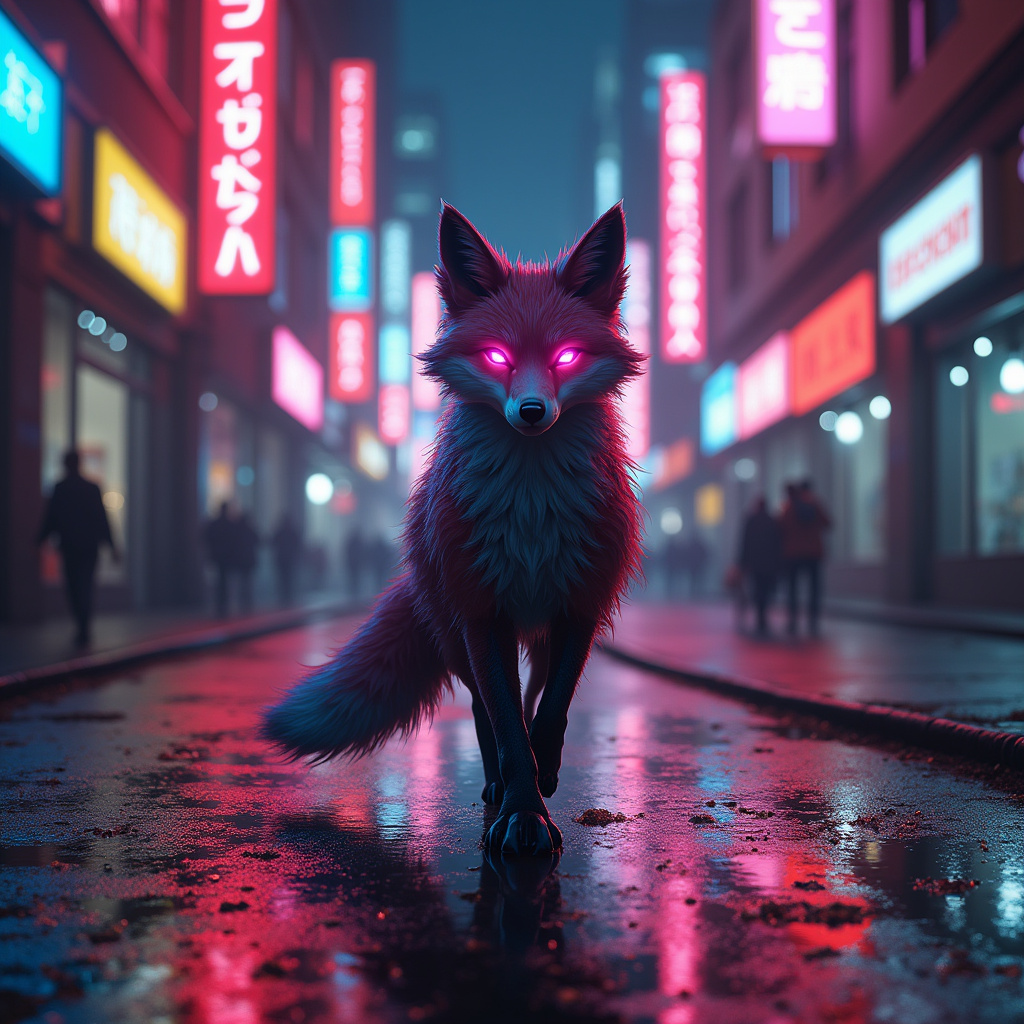

✅ Image uploaded to server


In [43]:
# import requests
# from PIL import Image
# from io import BytesIO
# import aiohttp  # optional, if you prefer an async request library

async def image_agent(project_id: str):
    # DO NOT overwrite project_id
    runware = Runware(api_key=RUNWARE_API_KEY)
    await runware.connect()

    request = IImageInference(
        positivePrompt="a cyberpunk fox walking through neon city streets at night",
        model="runware:101@1",
        width=1024,
        height=1024
    )

    images = await runware.imageInference(requestImage=request)
    image_url = images[0].imageURL

    # Download image
    response = requests.get(image_url)
    img_bytes = BytesIO(response.content)  # For uploading
    img = Image.open(img_bytes)
    display(img)

    # Prepare and upload image to FastAPI
    try:
        api_url = f"http://127.0.0.1:8000/api/project/upload-generated-image/{project_id}"

        # Create a "files" payload for a multipart/form-data PUT
        files = {
            "image_output": ("generated.png", img_bytes.getvalue(), "image/png")
        }

        res = requests.put(api_url, files=files)

        if res.status_code == 200:
            print("✅ Image uploaded to server")
        else:
            print("❌ Upload failed:", res.status_code, res.text)

    except Exception as e:
        print("Generation or upload failed:", e)

# ✅ To call it from a notebook or script:
import asyncio
await image_agent("68624961bf001fc12dd1df94")


In [54]:
def router_op(project_id: str):
    
    try:
        api_url =  f"http://127.0.0.1:8000/api/project/update/generated-output/{project_id}"

        res = requests.put(
            api_url,
            data={"project_id": project_id}
        )

        if res.status_code == 200:
            print("✅ Generated Output Linked to project")
            state["generationDone"] = "Generated"
    
    except Exception as e:
        print("Linking Failed:", e)

router_op("6863615a5f47abbe025c23e2")

✅ Generated Output Linked to project
